In [65]:
from __future__ import division, absolute_import, print_function
import os, sys, re
import numpy as np
from scipy import misc
from unrealcv import client
from pascal_voc_io import PascalVocWriter
import argparse
import json


DIFFICULT = 0
IMGSIZE = (1920, 1080, 3)

In [66]:
# Only for notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [69]:
# Fonction à revoir car non fonctionnelle.
def read_png(res):
    img = misc.imread(res)
    return np.asarray(img)

In [61]:
# Find solution to properly read png
res

'D:/Programmes/Epic Games/UE_4.13/Engine/Binaries/Win64/0.png'

In [56]:
class Color(object):
    ''' A utility class to parse color value '''
    regexp = re.compile('\(R=(.*),G=(.*),B=(.*),A=(.*)\)')

    def __init__(self, color_str):
        self.color_str = color_str
        match = self.regexp.match(color_str)
        (self.R, self.G, self.B, self.A) = [int(match.group(i)) for i in range(1, 5)]

    def __repr__(self):
        return self.color_str


def match_color(object_mask, target_color, tolerance=3):
    """Function that returns the coordinates of bbox associated with target_color mask
    The coordinates returned are (xmin, xmax, ymin, ymax)"""

    match_region = np.ones(object_mask.shape[0:2], dtype=bool)
    for c in range(3): # r,g,b
        min_val = target_color[c] - tolerance
        max_val = target_color[c] + tolerance
        channel_region = (object_mask[:,:,c] >= min_val) & (object_mask[:,:,c] <= max_val)
        match_region &= channel_region

    if match_region.sum() != 0:
        xbox, ybox = np.where(match_region)
        xmin, xmax = np.min(xbox), np.max(xbox)
        ymin, ymax = np.min(ybox), np.max(ybox)
        return xmin, xmax, ymin, ymax
    else:
        return None
    
    
def match_color_mask(object_mask, target_color, tolerance=3):
    match_region = np.ones(object_mask.shape[0:2], dtype=bool)
    for c in range(3): # r,g,b
        min_val = target_color[c] - tolerance
        max_val = target_color[c] + tolerance
        channel_region = (object_mask[:,:,c] >= min_val) & (object_mask[:,:,c] <= max_val)
        match_region &= channel_region

    if match_region.sum() != 0:
        return match_region
    else:
        return None


def get_id2color(scene_objects):
    id2color = {}  # Map from object id to the labeling color
    for obj_id in scene_objects:
        color = Color(client.request('vget /object/%s/color' % obj_id))
        id2color[obj_id] = color
    return id2color


def write_VOC(id2bbox, id2category, filename, foldername='database', imgSize=IMGSIZE):
    writer = PascalVocWriter(filename, foldername, imgSize)
    ids = id2bbox.values()
    for id in ids:
        xmin, xmax, ymin, ymax = id2bbox[id]
        name = id2category[id]
        writer.addBndBox(xmin, ymin, xmax, ymax, name, DIFFICULT)
    writer.save(foldername+'{}.xml'.format(filename))

In [57]:
client.connect()
if not client.isconnected():
    print('UnrealCV server is not running. Run the game downloaded from http://unrealcv.github.io first.')
    sys.exit(-1)
res = client.request('vget /unrealcv/status')
# The image resolution and port is configured in the config file.
print(res)

camera_trajectory = json.load(open('camera_traj.json'))
with open('object_category.json') as f:
    id2category = json.load(f)
print('done')

Is Listening
Client Connected
9000
Configuration
Config file: D:/Programmes/Epic Games/UE_4.13/Engine/Binaries/Win64/unrealcv.ini
Port: 9000
Width: 1920
Height: 1080

done


In [70]:
num_cameras = len(camera_trajectory)
# for idx in range(num_cameras):
idx = 0
loc, rot = camera_trajectory[idx]
client.request('vset /camera/{id}/location {x} {y} {z}'.format(id=idx, **loc))
client.request('vset /camera/{id}/rotation {pitch} {yaw} {roll}'.format(id=idx, **rot))
# Get image
res = client.request('vget /camera/{id}/lit {id}.png'.format(id=idx))
print('The image is saved to %s' % res)

custom_img = read_png(res)
print('image dimension : ', np.shape(custom_img))

# Generate image mask
res = client.request('vget /camera/{id}/object_mask mask_{id}.png'.format(id=idx))
object_mask = read_png(res)
print('mask dimension : ', np.shape(object_mask))

# Associate images to all objects ids
scene_objects = client.request('vget /objects').split(' ')
print('Number of objects in this scene:', len(scene_objects))

id2color = get_id2color(scene_objects)
id2bbox = {}
for obj_id in id2category:
    color = id2color[obj_id]
    bbox = match_color(object_mask, [color.R, color.G, color.B], tolerance=5)
    print(obj_id, bbox)
    if bbox is not None:
        id2bbox[obj_id] = bbox

The image is saved to D:/Programmes/Epic Games/UE_4.13/Engine/Binaries/Win64/0.png
image dimension :  (1080L, 1920L, 4L)
mask dimension :  (442L, 611L, 4L)
Number of objects in this scene: 93
rhinadvil11 None
rhinadvil10 None
rhinadvil13 (56, 89, 215, 289)
rhinadvil12 (60, 92, 68, 140)
rhinadvil3_191 None
rhinadvil14 (90, 123, 217, 290)
rhinadvil17 (277, 305, 442, 517)
drill-bleu3_208 None
rhinadvil19 (277, 427, 359, 507)
rhinadvil18 (252, 281, 444, 521)
dafalgan_133 None
novanuit2_167 None
drill-bleu_204 None
dafalgan2_135 None
nuronfen_408 (97, 132, 460, 537)
dafalgan4_139 (134, 236, 58, 77)
drill-bleu2_206 None
dafalgan14 (284, 318, 261, 293)
novanuit11 (352, 410, 394, 438)
dafalgan20 (99, 419, 71, 254)
dafalgan21 (285, 319, 297, 329)
rhinadvil2_189 None
novanuit3_169 (77, 289, 0, 134)
doliprane_otx_gelule_158 (331, 440, 62, 548)
dafalgan12 (379, 413, 221, 255)
novanuit_165 (329, 433, 0, 53)
dafalgan15 (343, 377, 220, 254)
rhinadvil16_263 (303, 333, 440, 515)
nuronfen_184 (104, 318,

In [46]:
obj_id = 'drill-bleu5_212'
tolerance = 3
color = id2color[obj_id]
target_color = (color.R, color.G, color.B)
match_region = np.ones(object_mask.shape[0:2], dtype=bool)
for c in range(3): # r,g,b
    min_val = target_color[c] - tolerance
    max_val = target_color[c] + tolerance
    channel_region = (object_mask[:,:,c] >= min_val) & (object_mask[:,:,c] <= max_val)
    print(np.where(True in channel_region))
    match_region &= channel_region

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [52]:
object_mask.shape

(442L, 611L, 4L)

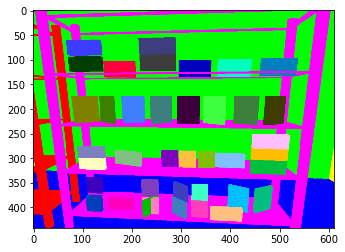

In [32]:
res = client.request('vget /camera/{id}/object_mask'.format(id=idx))
object_mask = read_png(res)
plt.imshow(object_mask)
plt.show()

Convention (xmin, xmax, ymin, ymax)

In [13]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(custom_img)
xmin, xmax, ymin, ymax = id2bbox['novanuit11']
print(xmin, xmax, ymin, ymax)
#rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
rect = patches.Rectangle((ymin,xmin),ymax-ymin,xmax-xmin, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

KeyError: 'novanuit11'

In [1]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(custom_img)
for (xmin, xmax, ymin, ymax) in id2bbox.values():
    
    #rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    rect = patches.Rectangle((ymin,xmin),ymax-ymin,xmax-xmin, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

NameError: name 'plt' is not defined

Constat : fonction semble fonctioner

In [ ]:
client.disconnect()